# バイアス-

In [1]:
from functools import partial
from dataclasses import dataclass
from typing import Any, Callable
from __future__ import annotations
import warnings

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
np.random.seed(42)

setting = {
    "style": "white",
    "palette": "deep",
    "font": "IPAexGothic",
    "rc": {
        "figure.dpi": 300,
        "figure.figsize": (6, 4),
        "axes.spines.right": False,
        "axes.spines.top": False,
        "axes.linewidth": 0.8,
        "axes.grid": True,
        "grid.color": ".8",
        "grid.linewidth": 0.5,
        "grid.linestyle": "dotted",
        "axes.edgecolor": ".3",
        "axes.labelcolor": ".3",
        "xtick.color": ".3",
        "ytick.color": ".3",
        "text.color": ".3",
        "figure.constrained_layout.use": True,
    },
}
sns.set(**setting)

warnings.simplefilter("ignore")

In [873]:
@dataclass
class Simulator:
    """シミュレーションとその結果の可視化を行うクラス

    Args:
        n_sample:
        f:
        n_grids: Xの
    """

    n_sample: int
    f: Callable[[np.ndarray], np.ndarray]
    n_grids: int = 100

    def __post_init__(self) -> None:
        """理論値を作成"""
        
        # Xの範囲をグリッドで分割
        self.X_theory = np.linspace(start=0, stop=1, num=self.n_grids)
        # f(X)で理論値を作成
        self.y_theory = self.f(self.X_theory)

    def generate_simulation_data(self) -> tuple[np.ndarray, np.ndarray]:
        """シミュレーション用のデータを生成する
        
        Returns:
            特徴量と目的変数のtuple
        """

        # Xは一様分布から、yは正規分布から生成する
        X = np.random.uniform(low=0, high=1, size=self.n_sample)
        u = np.random.normal(loc=0, scale=1, size=self.n_sample)
        # 関数f(X)を噛ませてノイズを足して目的変数とする
        y = self.f(X) + u

        return (X, y)

    def simulate(
        self,
        estimators: dict[str, Any],
        n_simulations: int,
    ) -> dict[str, np.ndarray]:
        """シミュレーションデータを生成して、学習と予測を行う
        
        Args:
            estimators: シミュレーション用のモデル
            n_simulations: シミュレーション回数
        Returns:
            モデルごとの予測値がまとまった辞書
        """

        y_preds = {
            k: np.zeros((self.n_grids, n_simulations)) for k in estimators.keys()
        }
        for s in range(n_simulations):
            X, y = self.generate_simulation_data()
            for k, estimator in estimators.items():
                y_preds[k][:, s] = estimator.fit(X.reshape(-1, 1), y).predict(
                    self.X_theory.reshape(-1, 1)
                )

        return y_preds

    def decompose_bias_variance(
        self,
        y_preds: dict[str, np.ndarray],
    ) -> dict[dtr, dict[str, np.ndarray]]:
        """
        Args:
            y_preds: モデルごとの予測値
        Returns:
            BiasとVarianceがまとまった辞書
        """

        bias = {
            k: (self.y_theory - y_pred.mean(axis=1)) ** 2
            for k, y_pred in y_preds.items()
        }
        variance = {k: y_pred.var(axis=1) for k, y_pred in y_preds.items()}

        return {"Bias": bias, "Variance": variance}

    def draw_prediction(
        self,
        y_preds: dict[str, np.ndarray],
        estimator_key: int,
        simulation_ids: list[int],
        ylim: tuple(float, float) | None = None,
    ) -> None:
        """予測結果を可視化
        
        Args:
            y_preds: 
            estimator_key: 
            simulation_ids: 
            ylim: 
        """

        if ylim is None:
            y = np.concatenate([y for y in y_preds.values()])
            ylim = (y.min(), y.max())

        fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
        axes[0].plot(self.X_theory, self.y_theory, color=".3", linewidth=2, label="理論値")

        for s in simulation_ids:
            axes[0].plot(
                self.X_theory,
                y_pred[estimator_key][:, s],
                linewidth=0.1,
                color=sns.color_palette()[0],
                label=f"予測値（シミュレーション{s:02.0f}）",
            )
        axes[0].set(xlabel="X", ylabel="Y", ylim=ylim, title="Varianceの可視化")

        axes[1].plot(
            self.X_theory,
            y_pred[estimator_key].mean(axis=1),
            linewidth=2,
            label=f"予測値（シミュレーションの平均）",
        )
        axes[1].plot(self.X_theory, self.y_theory, color=".3", linewidth=2, label="理論値")
        axes[1].legend()
        axes[1].set(xlabel="X", ylabel="Y", ylim=ylim, title="Biasの可視化")

        fig.suptitle(f"{estimator_key}のBiasとVarianceを可視化")
        fig.show()

    def draw_bias_variance(
        self, bias_variances: dict[str, dict[str, np.ndarray]]
    ) -> None:
        """
        Args:
            bias_variances: 
        """

        fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
        for ax, (k, bvs) in zip(axes, bias_variances.items()):
            for estimator_key, value in bvs.items():
                ax.plot(
                    self.X_theory,
                    value,
                    linewidth=1,
                    label=f"{estimator_key}",
                )
                ax.legend()
                ax.set(xlabel="X", title=k)
        fig.suptitle(f"モデルごとのBias-Varianceの比較")
        fig.show()

In [874]:
s = Simulator(n_sample=1000, f=lambda X: np.sin(6 * np.pi * X))

dts = {
    "DT01": DecisionTreeRegressor(max_depth=1),
    "DT10": DecisionTreeRegressor(max_depth=10),
}
y_preds = s.simulate(estimators=dts, n_simulations=100)
bias_variances = s.decompose_bias_variance(y_preds)

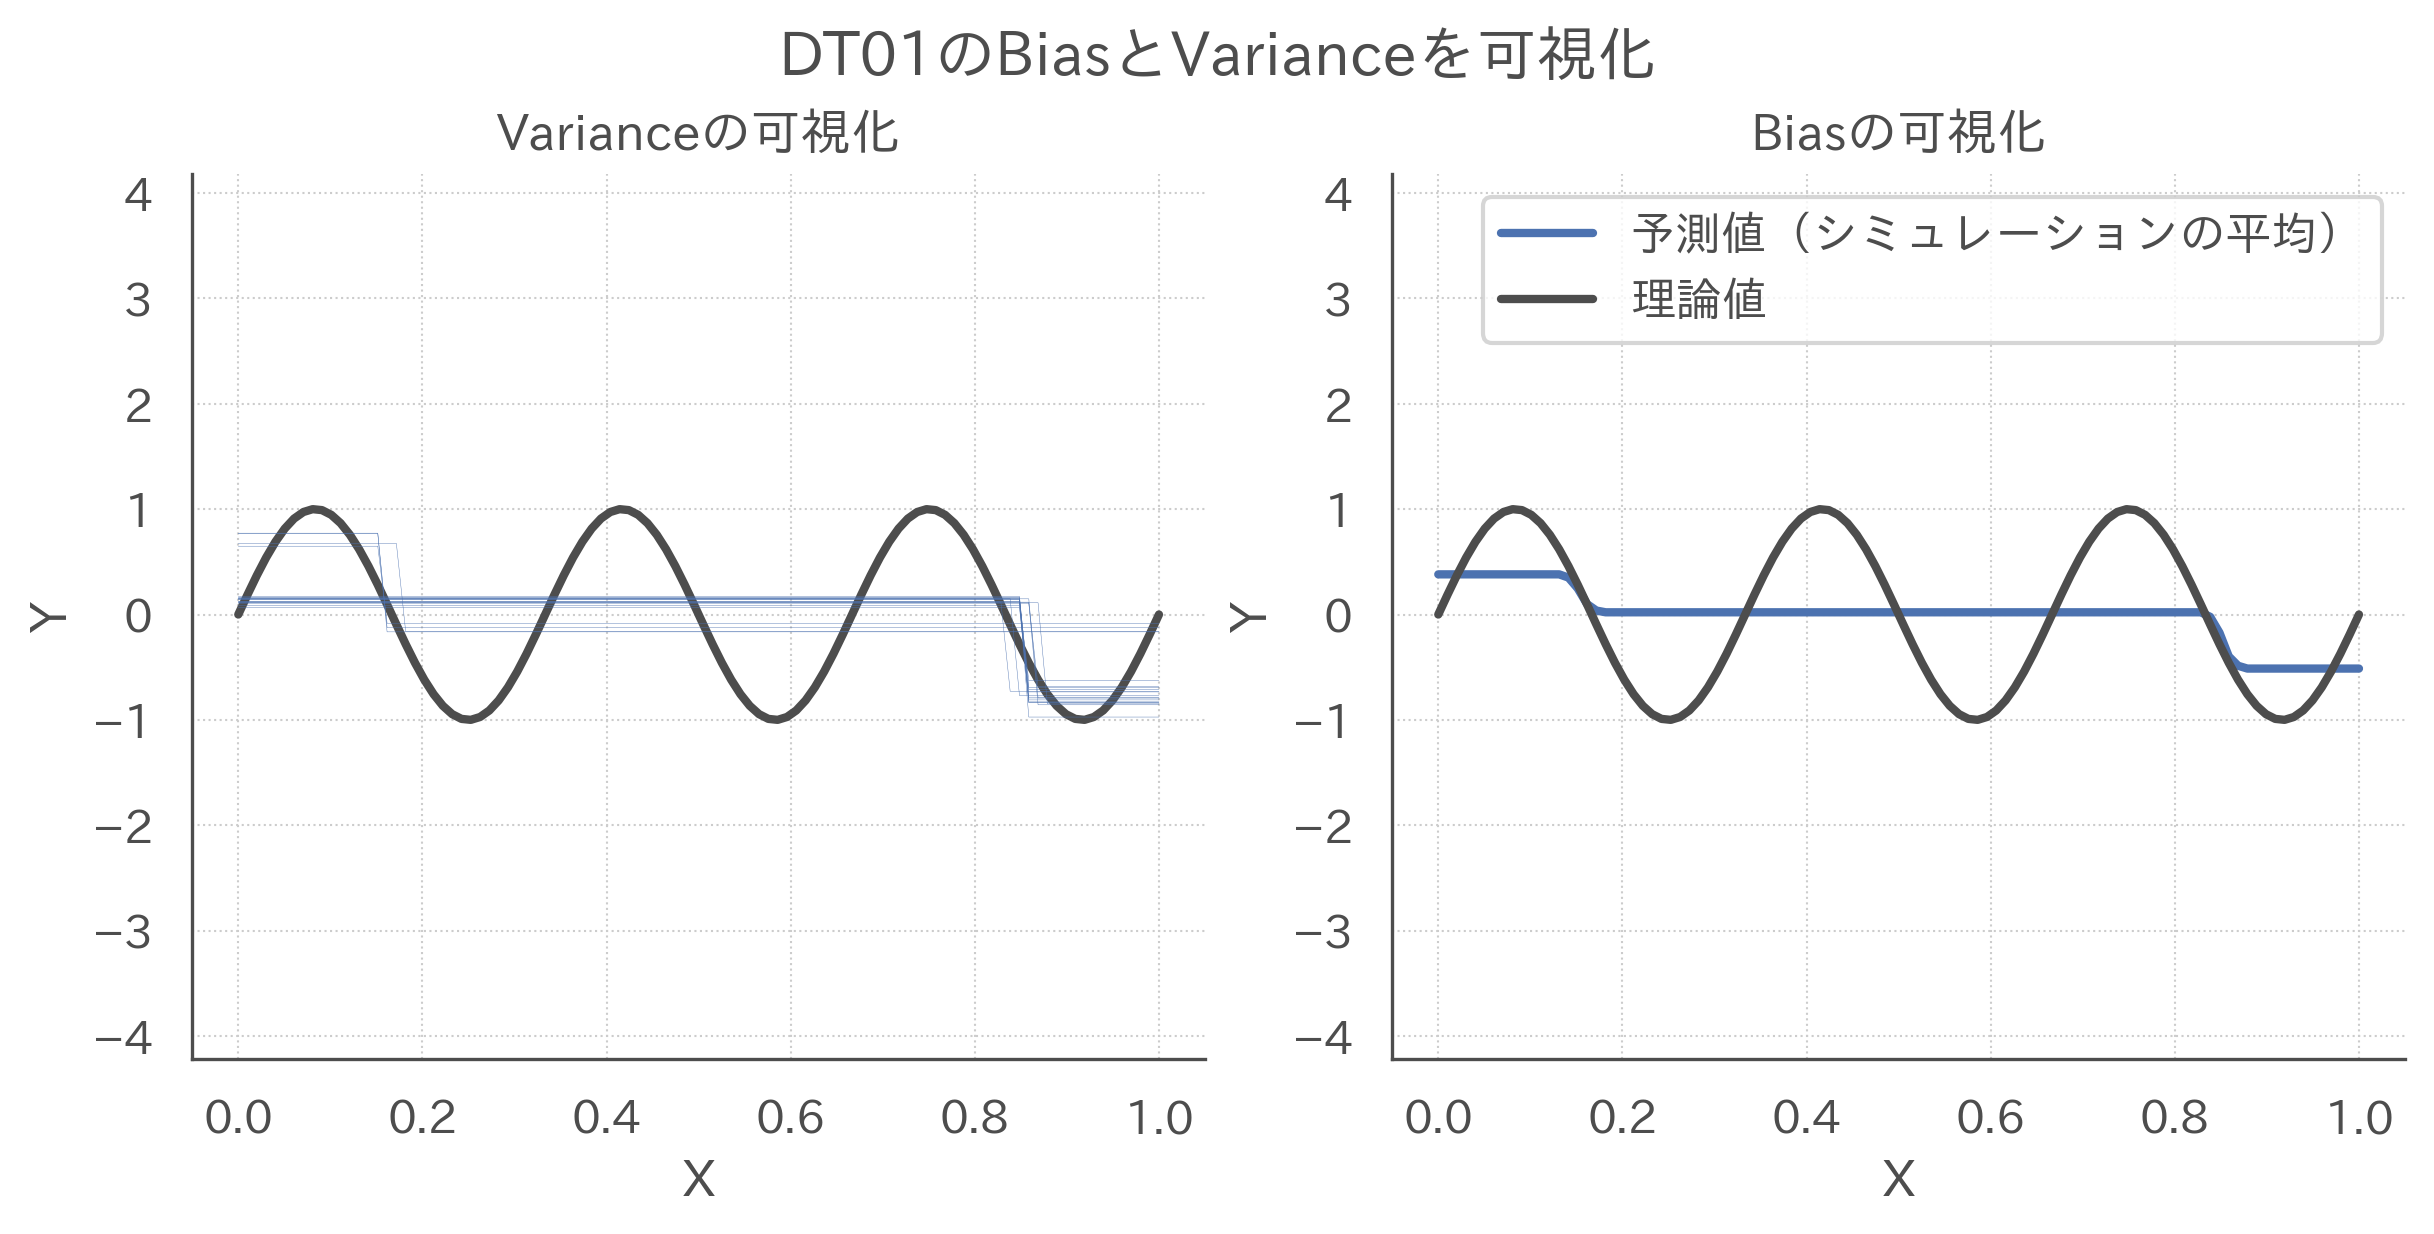

In [868]:
s.draw_prediction(y_preds=y_preds, simulation_ids=range(20), estimator_key='DT01')

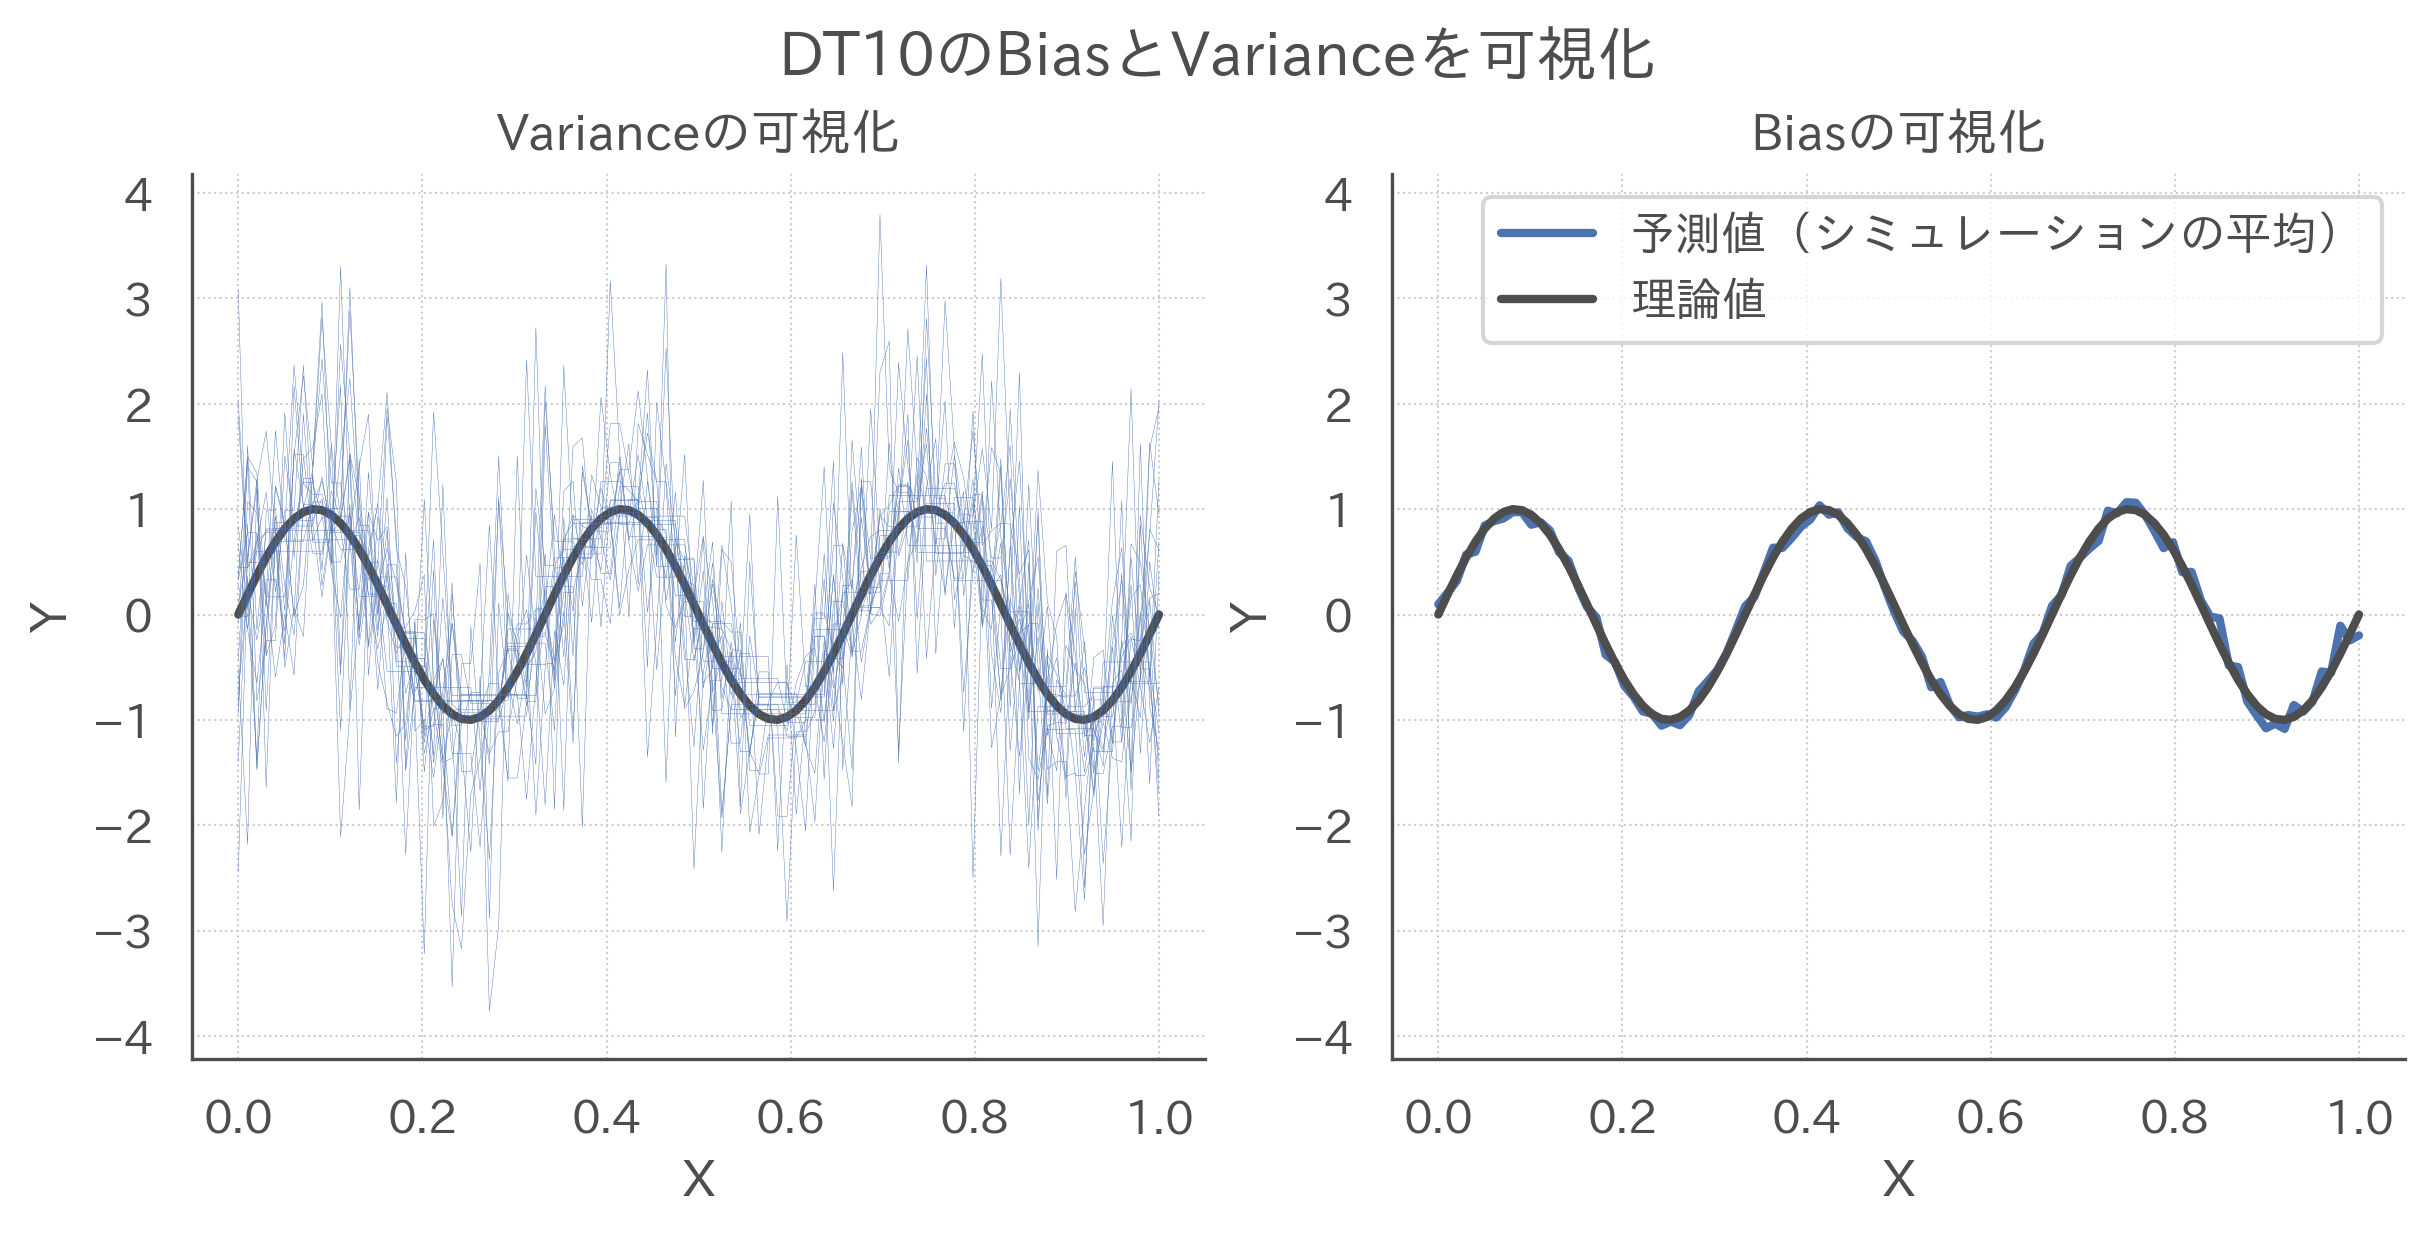

In [869]:
s.draw_prediction(y_preds=y_preds, simulation_ids=range(20), estimator_key='DT10')

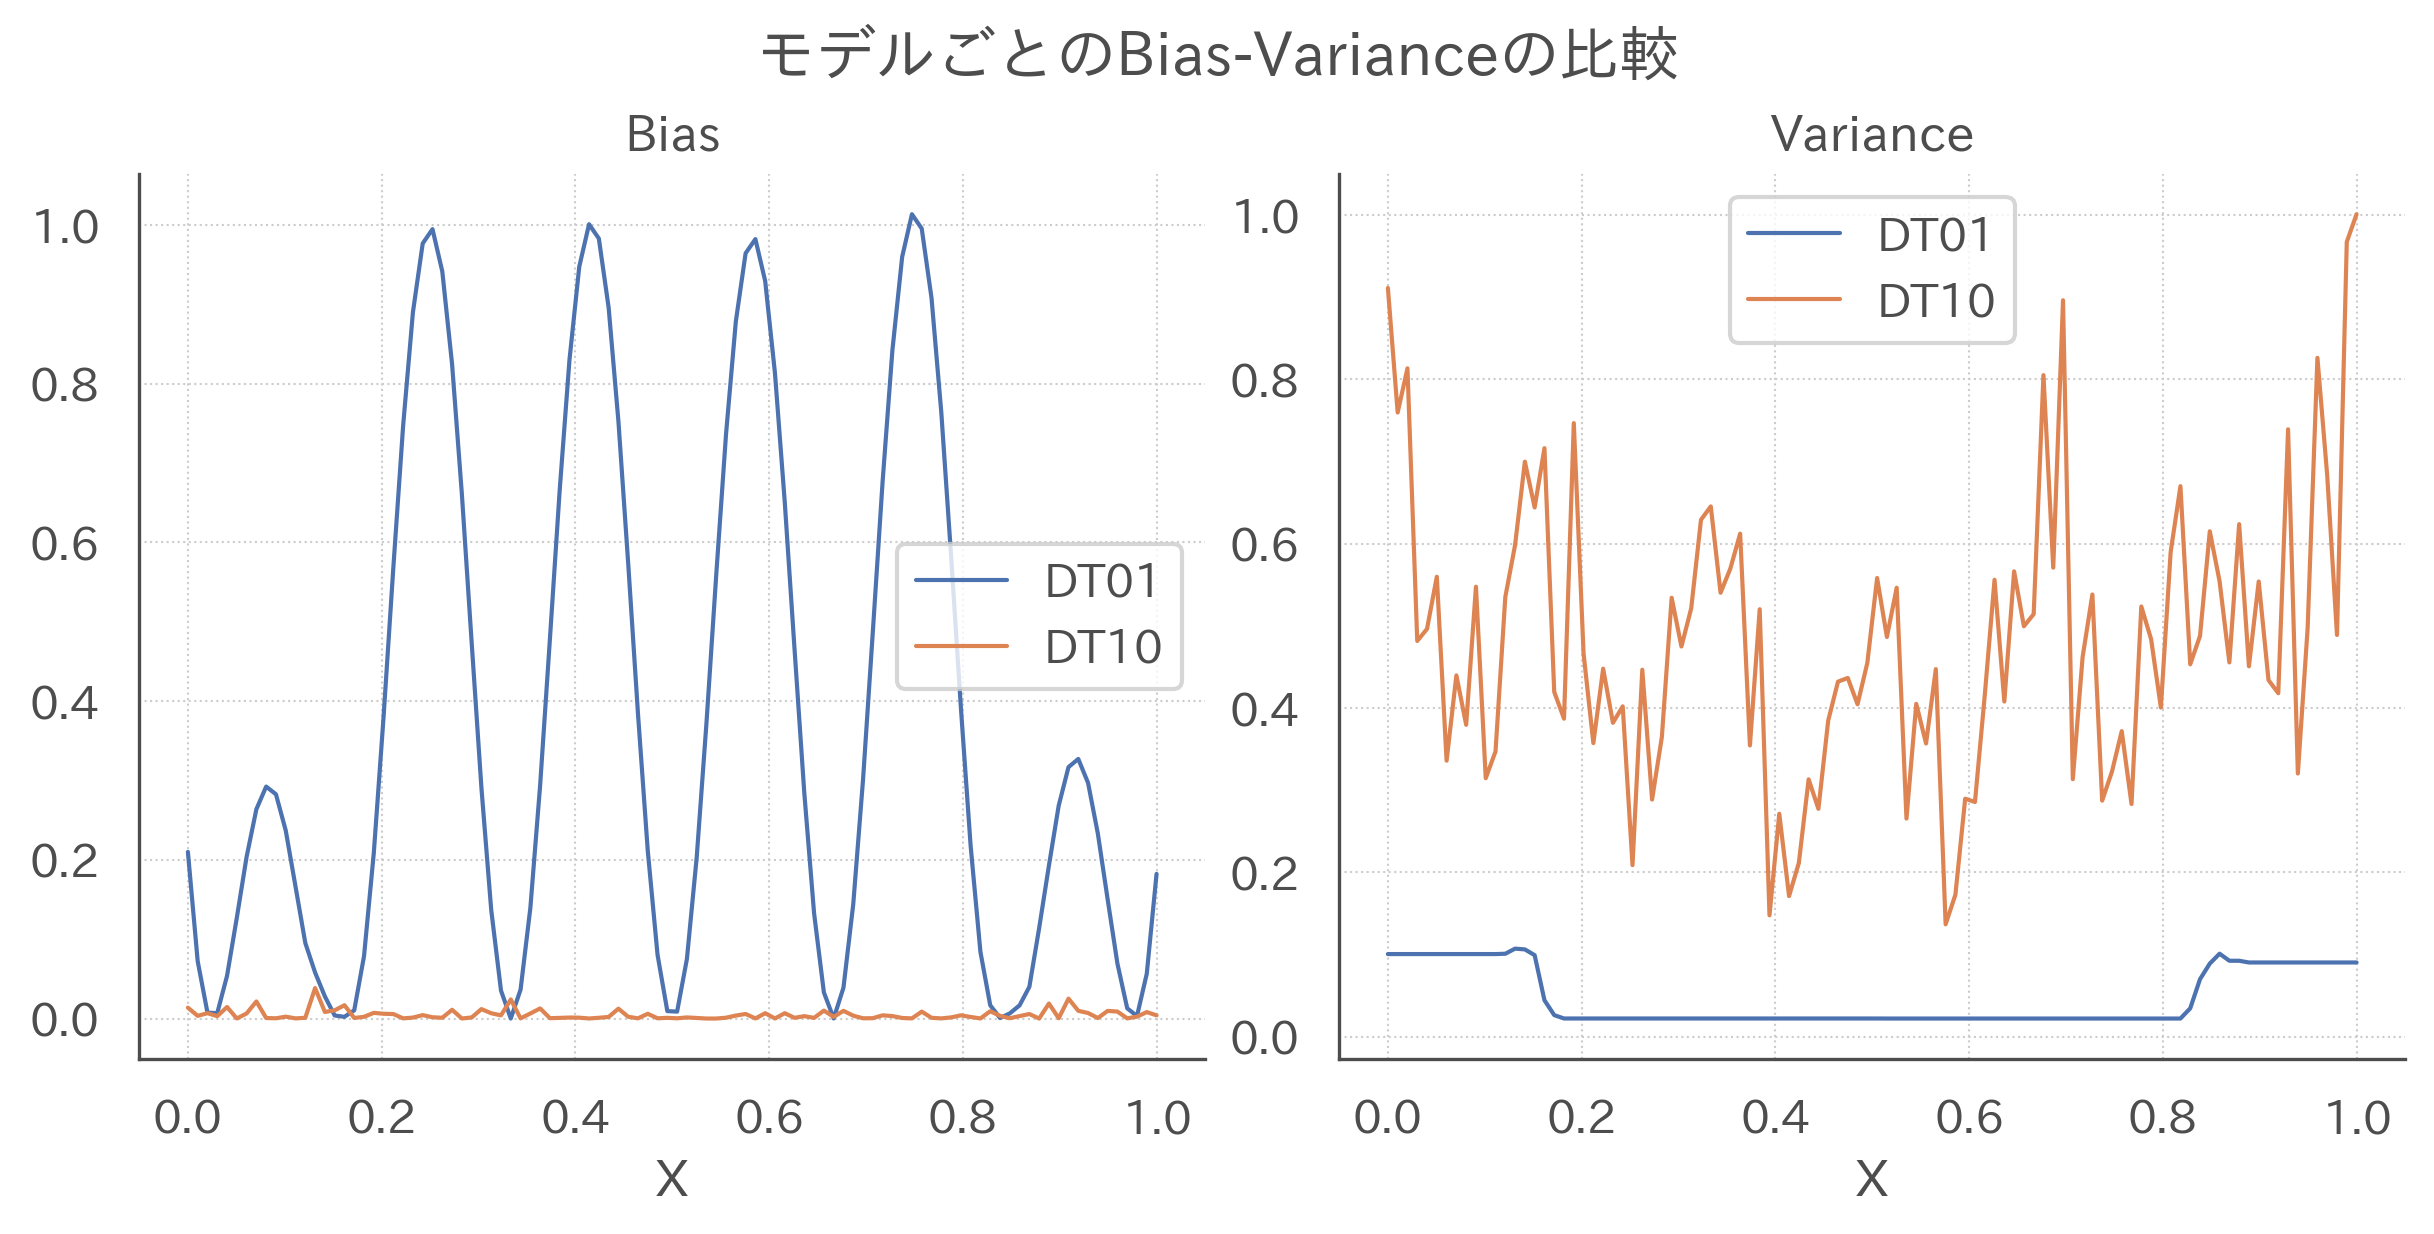

In [870]:
s.draw_bias_variance(bias_variances=bias_variances)

In [791]:
@dataclass
class Simulator:
    n_sample: int
    f: Callable[[np.ndarray], np.ndarray]

    def __post_init__(self) -> None:
        """"""
        self.n_grids = 100
        self.X_theory = np.linspace(start=0, stop=1, num=self.n_grids)
        self.y_theory = self.f(self.X_theory)

    def generate_simulation_data(self) -> tuple[np.ndarray, np.ndarray]:
        """"""
        X = np.random.uniform(low=0, high=1, size=self.n_sample)
        u = np.random.normal(loc=0, scale=1, size=self.n_sample)
        y = self.f(X) + u

        return (X, y)

    def simulate(self, estimators: dict[str, Any], n_simulations: int) -> np.ndarray:
        """"""
        self.estimator_label = list[estimators.keys()]
        y_pred = np.zeros((self.n_grids, n_simulations, len(estimators)))
        for s in range(n_simulations):
            X, y = self.generate_simulation_data()
            for e, estimator in enumerate(estimators.values):
                y_pred[:, s, e] = (
                    estimator
                    .fit(X.reshape(-1, 1), y)
                    .predict(self.X_theory.reshape(-1, 1))
                )

        return y_pred

    def decompose_bias_variance(
        self, y_pred: np.ndarray
    ) -> tuple(np.ndarray, np.ndarray, np.ndarray):
        """"""

        bias = (self.y_theory.reshape(-1, 1) - y_pred.mean(axis=1)) ** 2
        variance = y_pred.var(axis=1)
        mse = np.mean((self.y_theory.reshape(-1, 1, 1) - y_pred) ** 2, axis=1)

        return (bias, variance, mse)

    def draw_prediction(
        self,
        y_pred: np.ndarray,
        simulation_ids: list[int],
        estimator_id: int,
        ylim: tuple(float, float) | None = None,
    ) -> None:

        if ylim is None:
            ylim = (y_pred.min(), y_pred.max())

        fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
        axes[0].plot(self.X_theory, self.y_theory, color=".3", linewidth=2, label="理論値")
        
        for s in simulation_ids:
            axes[0].plot(
                self.X_theory,
                y_pred[:, s, estimator_id],
                linewidth=0.1,
                color = sns.color_palette()[0],
                label=f"予測値（シミュレーション{s:02.0f}）",
            )
        #axes[0].legend()
        axes[0].set(xlabel="X", ylabel="Y", ylim=ylim, title="Varianceの可視化")

        axes[1].plot(
            self.X_theory,
            y_pred[:, :, estimator_id].mean(axis=1),
            linewidth=2,
            label=f"予測値（シミュレーションの平均）",
        )
        axes[1].plot(self.X_theory, self.y_theory, color=".3", linewidth=2, label="理論値")
        axes[1].legend()
        axes[1].set(xlabel="X", ylabel="Y", ylim=ylim, title="Biasの可視化")

        fig.suptitle(f"モデル{estimator_id}のBiasとVarianceを可視化")
        fig.show()

    def draw_bias_variance(self, bias_variance: tuple(np.ndarray, np.ndarray)) -> None:
        """"""

        fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
        for j in range(2):
            for e in range(bias_variance[j].shape[1]):
                axes[j].plot(
                    self.X_theory,
                    bias_variance[j][:, e],
                    linewidth=1,
                    label=f"モデル{e:02.0f}",
                )
            axes[j].legend()

            axes[j].set(xlabel="X", title=["Bias", "Variance"][j])
        fig.suptitle(f"モデルごとのBias-Varianceの比較")
        fig.show()

In [787]:
s = Simulator(n_sample=1000, f=lambda x: np.sin(6 * np.pi * x))

dts = [DecisionTreeRegressor(max_depth=1), DecisionTreeRegressor(max_depth=10)]
y_pred = s.simulate(estimators=dts, n_simulations=100)
bias, variance, mse = s.decompose_bias_variance(y_pred)

In [820]:
s.draw_prediction(y_pred=y_pred, simulation_ids=range(50), estimator_id=0)

TypeError: draw_prediction() got an unexpected keyword argument 'estimator_id'

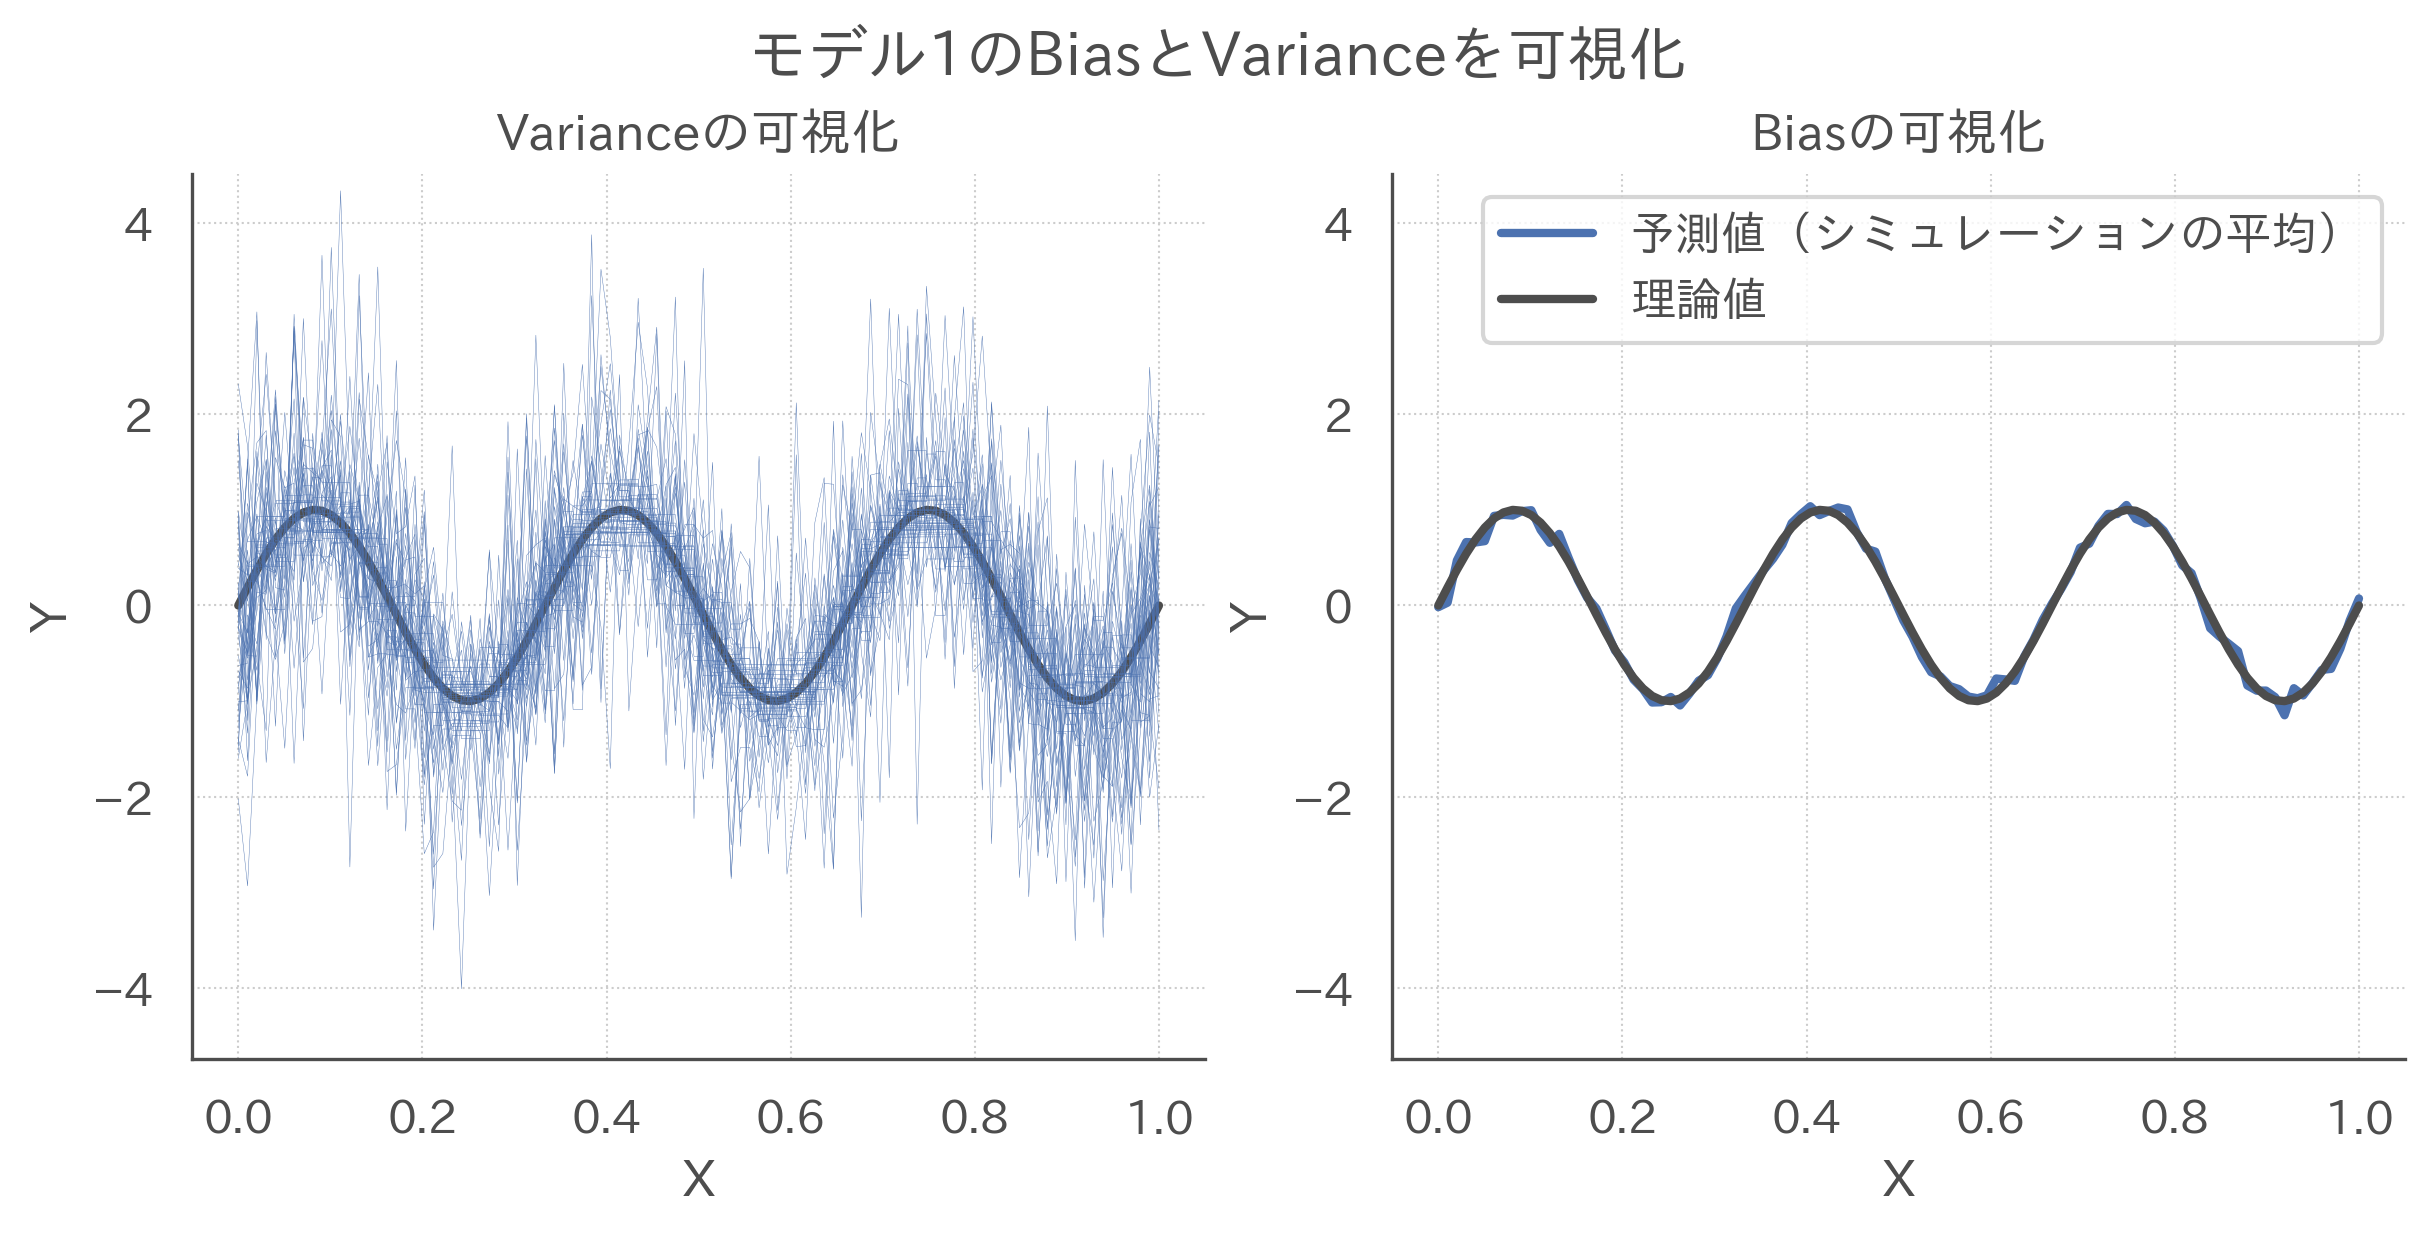

In [789]:
s.draw_prediction(y_pred=y_pred, simulation_ids=range(50), estimator_id=1)

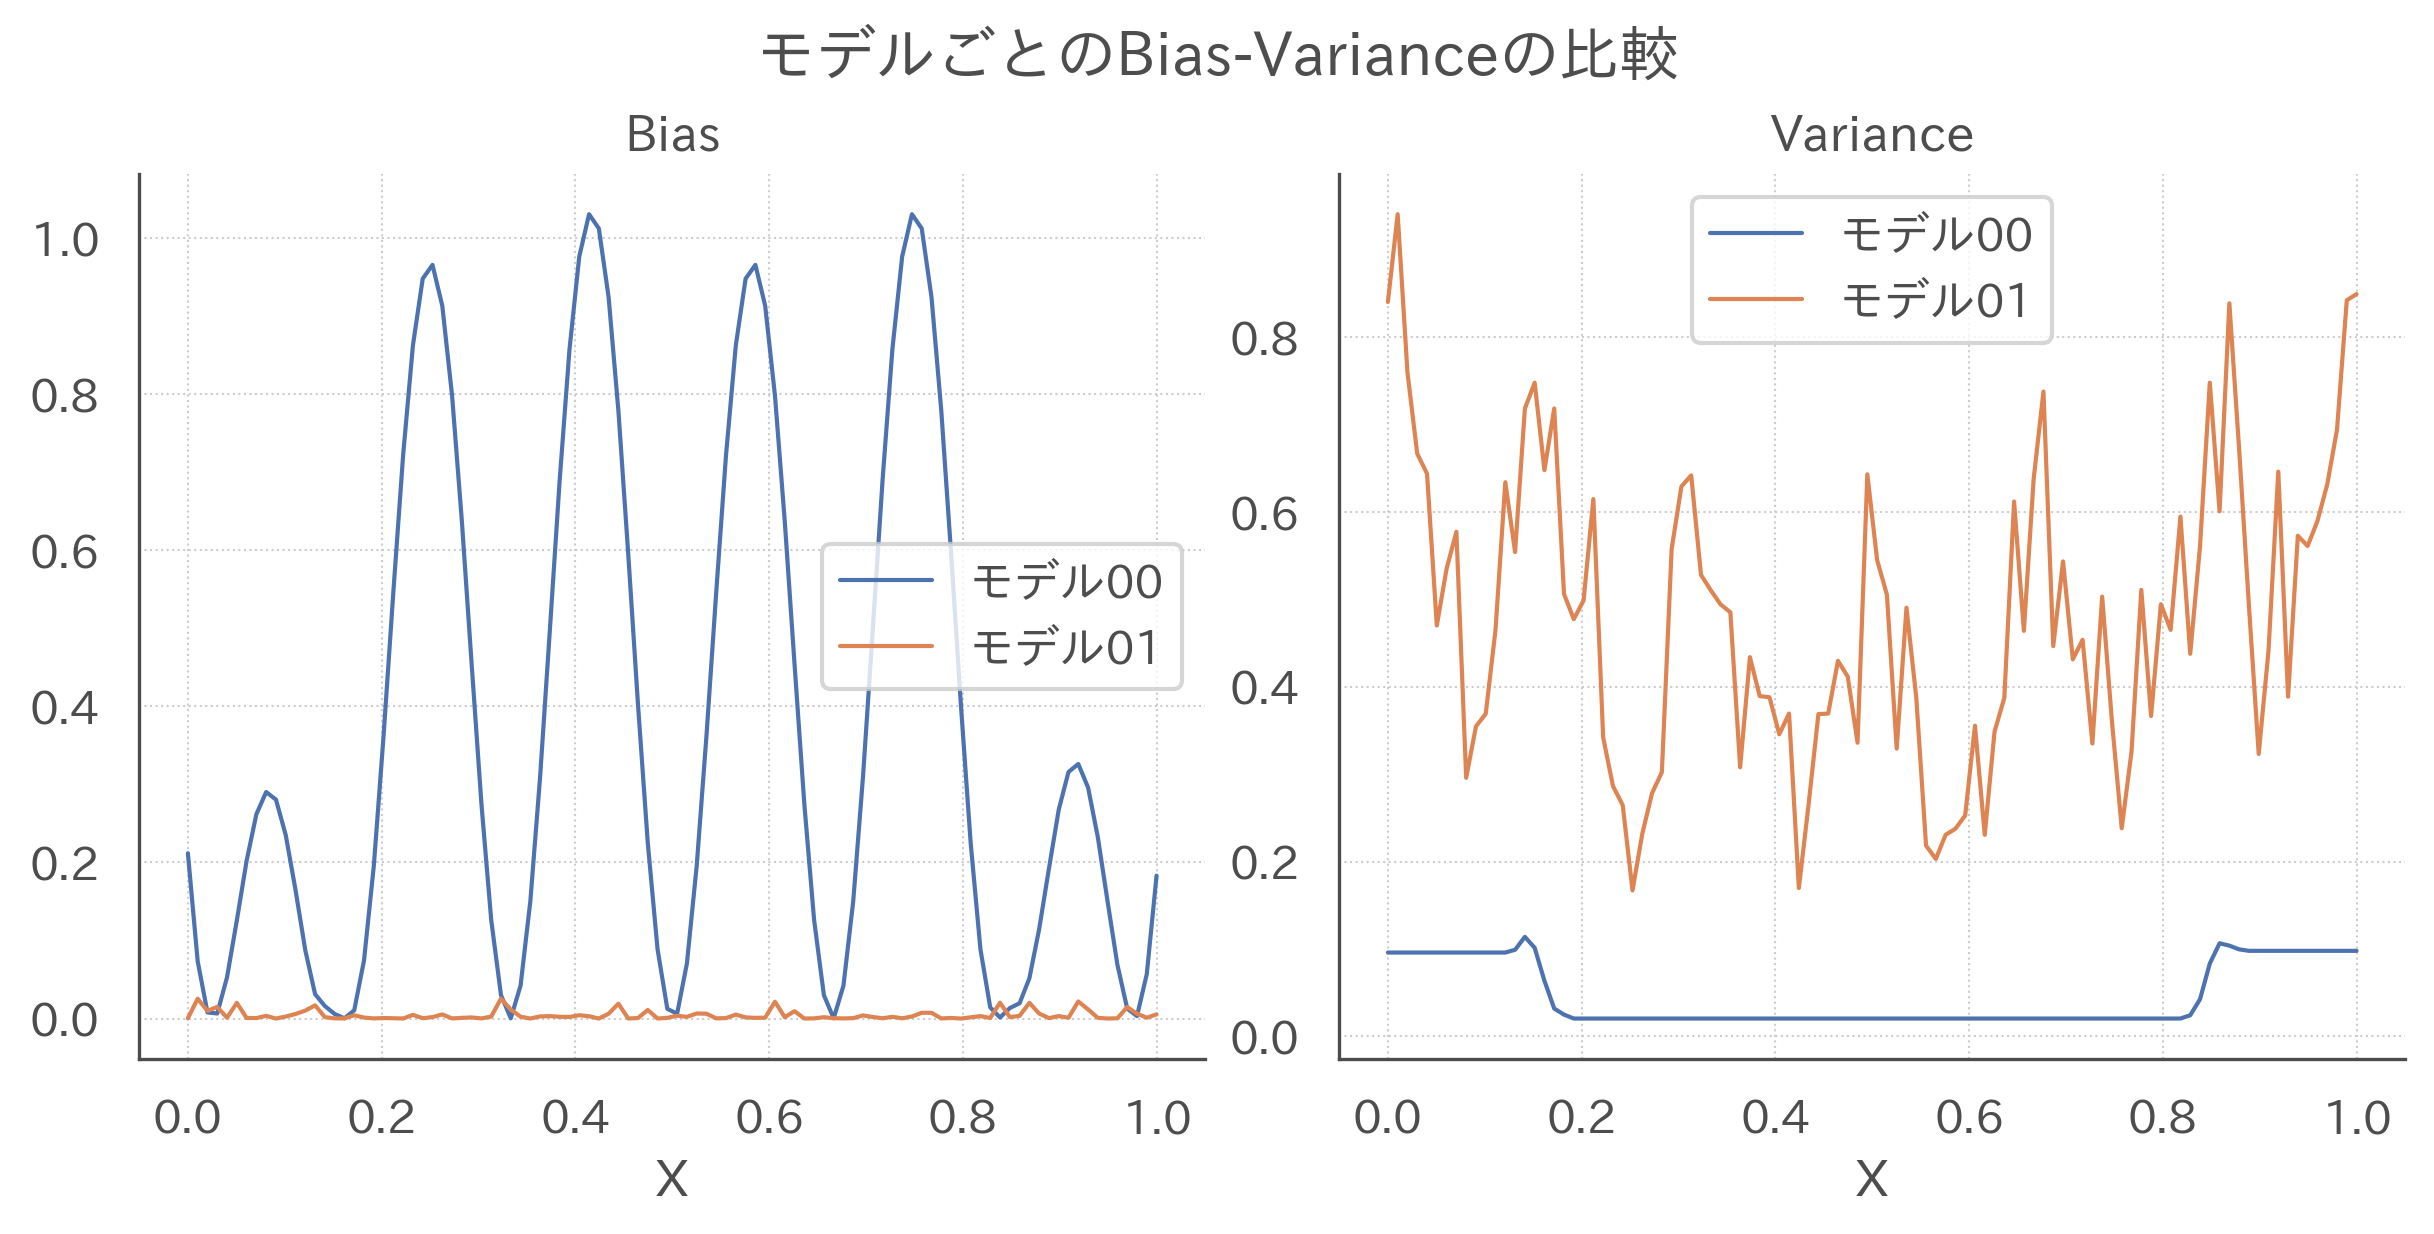

In [790]:
s.draw_bias_variance((bias, variance))

In [772]:
max_depth_range = range(1, 11)
dts = [DecisionTreeRegressor(max_depth=x) for x in max_depth_range]

s = Simulator(n_sample=1000, f=lambda x: np.sin(6 * np.pi * x))
y_pred = s.simulate(estimators=dts, n_simulations=100)
bias, variance, mse = s.decompose_bias_variance(y_pred)

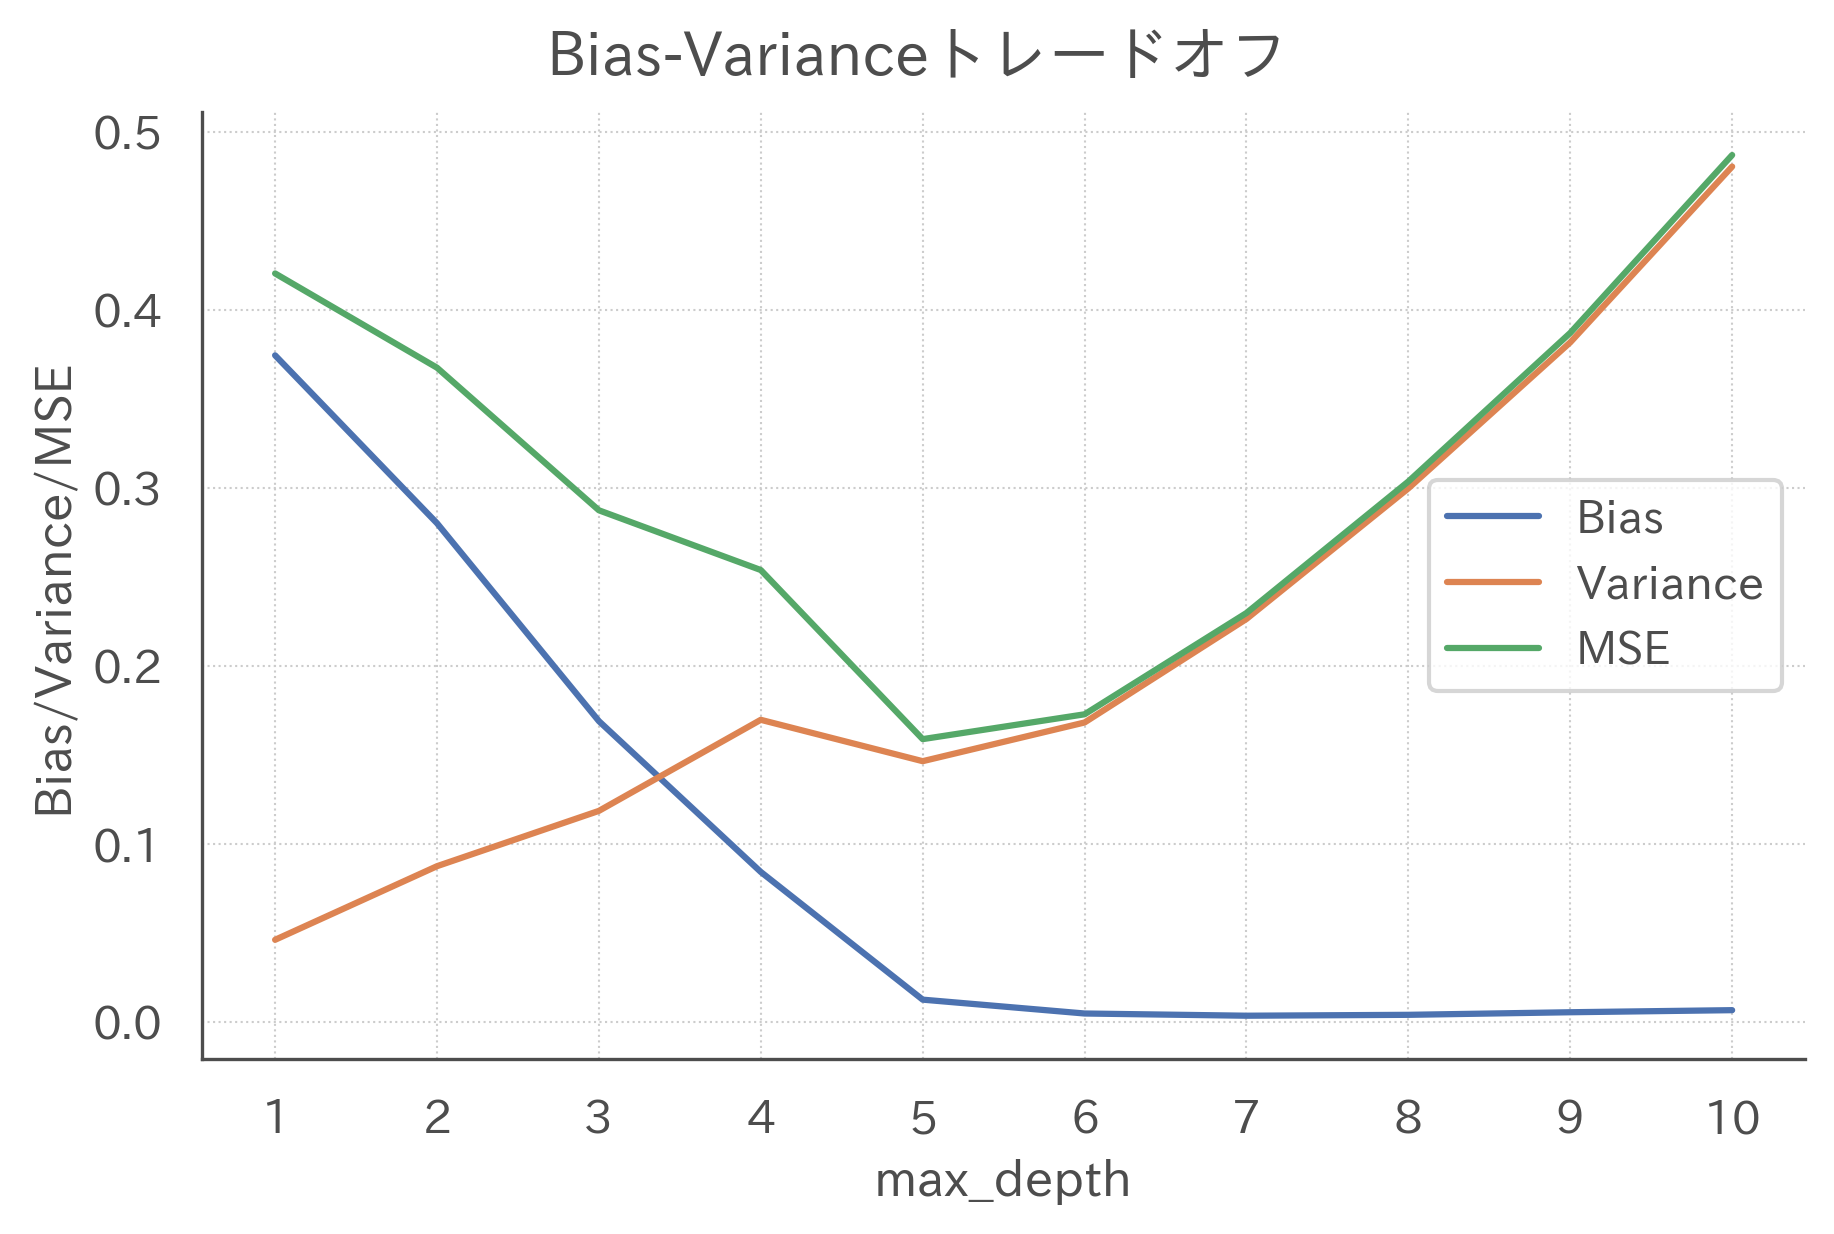

In [773]:
def draw_bias_variance_tradeoff(
    bias: np.ndarray, variance: np.ndarray, mse: np.ndarray
) -> None:
    fig, ax = plt.subplots()
    ax.plot(max_depth_range, bias, label="Bias")
    ax.plot(max_depth_range, variance, label="Variance")
    ax.plot(max_depth_range, mse, label="MSE")
    ax.legend()
    ax.set_xticks(max_depth_range)
    ax.set(xlabel="max_depth", ylabel="Bias/Variance/MSE")
    fig.suptitle("Bias-Varianceトレードオフ")
    fig.show()


draw_bias_variance_tradeoff(bias.mean(axis=0), variance.mean(axis=0), mse.mean(axis=0))

In [774]:
@dataclass
class BaggingTreeRegressor:
    n_estimators: int
    tree_params: dict
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> BaggingRegressor:
        """"""
        
        n_sample = X.shape[0]

        ids = np.random.choice(n_sample, size=(self.n_estimators, n_sample))
        self.estimators = []
        for e in range(self.n_estimators):
            self.estimators.append(DecisionTreeRegressor(**self.tree_params).fit(X[ids[e]], y[ids[e]]))

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """"""
        return np.column_stack([e.predict(X) for e in self.estimators]).mean(axis=1)

In [775]:
dts = [
    DecisionTreeRegressor(max_depth=10),
    BaggingTreeRegressor(n_estimators=100, tree_params={'max_depth': 10}),
]
#s = Simulator(n_sample=1000, f=lambda x: np.sin(6 * np.pi * x))
y_pred = s.simulate(estimators=dts, n_simulations=100)
bias, variance, mse = s.decompose_bias_variance(y_pred)

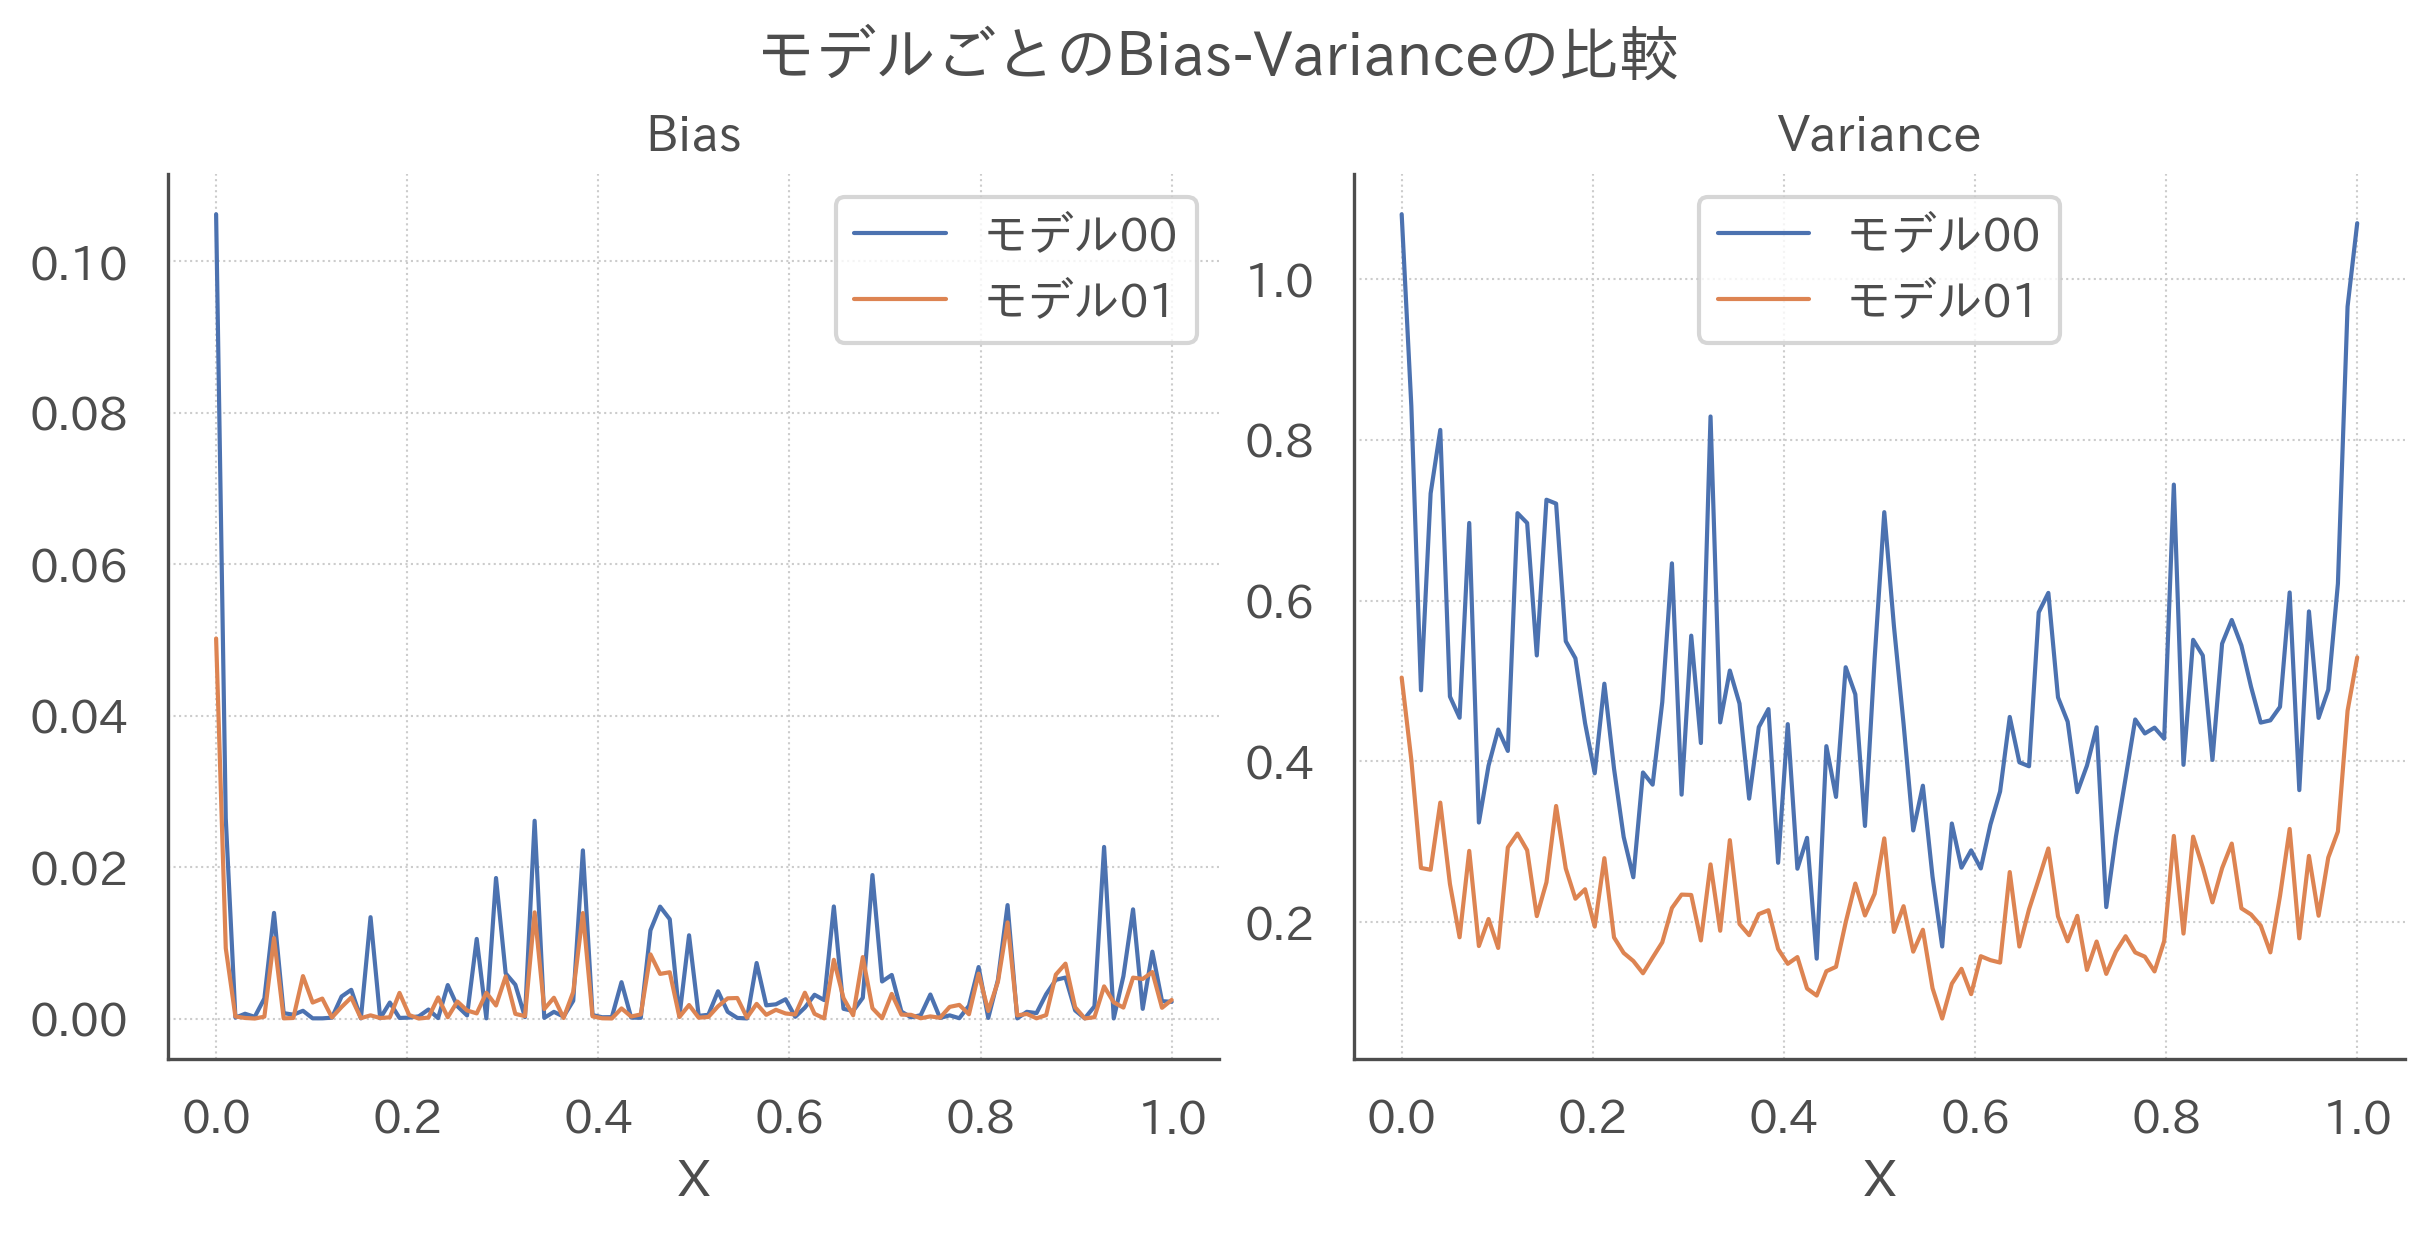

In [776]:
s.draw_bias_variance((bias, variance))

In [731]:
class BaggingTreeRegressor2(BaggingTreeRegressor):
    def predict(self, X: np.ndarray) -> np.ndarray:
        """"""
        return np.column_stack([e.predict(X) for e in self.estimators])


class Simulator2(Simulator):
    def simulate(self, estimator: Any, n_simulations: int) -> np.ndarray:
        """"""

        y_pred = np.zeros((self.n_grids, estimator.n_estimators, n_simulations))
        for s in range(n_simulations):
            X, y = self.generate_simulation_data()
            y_pred[:, :, s] = estimator.fit(X.reshape(-1, 1), y).predict(
                self.X_theory.reshape(-1, 1)
            )

        return y_pred

In [734]:
s = Simulator2(n_sample=1000, f=lambda x: np.sin(6 * np.pi * x))
bt = BaggingTreeRegressor2(n_estimators=100, tree_params={"max_depth": 10})
y_pred = s.simulate(estimator=bt, n_simulations=100)
bias, variance, mse = s.decompose_bias_variance(y_pred.mean(axis=1))

In [735]:
C = np.cov(y_pred[0], bias=True)
mask = np.eye(C.shape[0], dtype=bool)
print(C[mask].sum() / (100 ** 2))
print(C[~mask].sum() / (100 ** 2))

0.010740481773411113
0.49121017866064104


In [736]:
C[mask].mean()

1.0740481773411112

In [740]:
np.corrcoef(y_pred[0])[~mask].mean()

array([0.41116108, 0.56824194, 0.54875458, ..., 0.31847569, 0.4341596 ,
       0.42738854])

In [738]:
C[mask].mean() * np.corrcoef(y_pred[0])[~mask].mean()

0.4956287304675143

In [739]:

np.cov(y_pred[0], bias=True).sum() / (100**2)

0.5019506604340521